In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
import imodelsx.util
import sasc.viz
import pickle as pkl
from PIL import Image
import img2pdf
import json
from copy import deepcopy
from numpy.linalg import norm
from math import ceil
from sasc.config import CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir, FMRI_DIR
import sasc.modules.fmri_module
ngrams_list = joblib.load(join(cache_ngrams_dir, 'fmri_UTS02_ngrams.pkl')) # ngrams are same for both models

# subject = 'S01'
subject = 'S03'
# subject = 'S02'
# suffix_setting = '_fedorenko'
# suffix_setting = ''
suffix_setting = '_spotlights'

if suffix_setting == '':
    # rois_dict = joblib.load(join(regions_idxs_dir, f'rois_{subject}.jbl'))
    # rois = joblib.load(join(FMRI_DIR, 'brain_tune/voxel_neighbors_and_pcs/', 'communication_rois_UTS02.jbl'))
    rois = joblib.load(join(FMRI_DIR, 'brain_tune/voxel_neighbors_and_pcs/',
                            f'communication_rois_v2_UT{subject}.jbl'))
    rois_dict_raw = {i: rois[i] for i in range(len(rois))}
    if subject == 'S02':
        raw_idxs = [
            [0, 7],
            [3, 4],
            [1, 5],
            [2, 6],
        ]
    elif subject == 'S03':
        raw_idxs = [
            [0, 7],
            [3, 4],
            [2, 5],
            [1, 6],
        ]
    rois_dict = {
        i: np.vstack([rois_dict_raw[j] for j in idxs]).sum(axis=0)
        for i, idxs in enumerate(raw_idxs)
    }
elif suffix_setting == '_fedorenko':
    if subject == 'S03':
        rois_fedorenko = joblib.load(join(FMRI_DIR, 'brain_tune/voxel_neighbors_and_pcs/', 'lang_localizer_UTS03.jbl'))
    rois_dict = {
        i: rois_fedorenko[i] for i in range(len(rois_fedorenko))
    }
    # rois_dict = rois_dict_raw
elif suffix_setting == '_spotlights':
    rois_spotlights = joblib.load(f'all_spotlights_UT{subject}.jbl')
    rois_dict = {i: rois_spotlights[i][-1] for i in range(len(rois_spotlights))}

/home/chansingh/.env/lib/python3.11/site-packages/cortex/blender/__init__.py:5: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


### Visualize ROIs
Make sure these actually look right (esp. with contralateral regions)

100%|██████████| 8/8 [00:36<00:00,  4.56s/it]


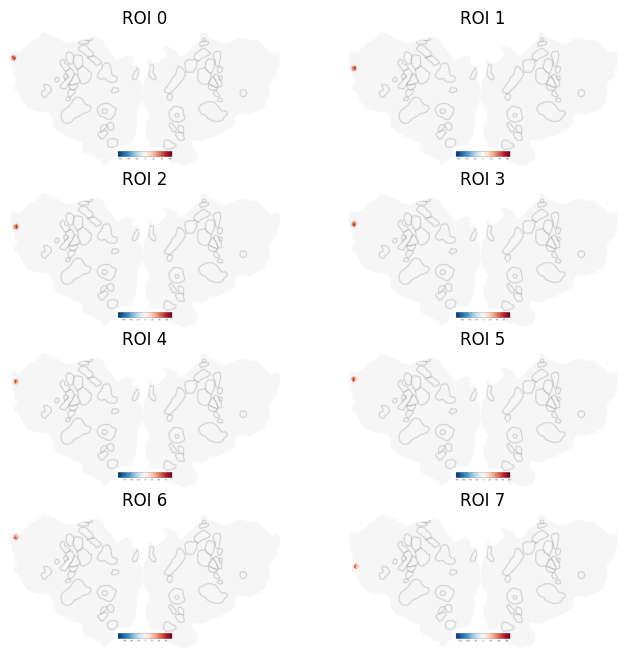

In [2]:
# # # save pcs
n_rois = min(8, len(rois_dict))
for i in tqdm(range(n_rois)):
    flatmap = rois_dict[i]
    # flatmap = np.zeros(weights_arr_full.shape[1])
    # flatmap[pfc] = pc_coefs_per_voxel[:, pc_num]
    sasc.viz._save_flatmap(
        flatmap, subject, fname_save=f'rois_custom_images/communication_{i}_{subject}.png')

# read all plots and save as subplots on the same page
C = 2
R = ceil(n_rois/C)
fig, axs = plt.subplots(R, C, figsize=(C * 4, R * 2))
axs = axs.ravel()
for i in range(n_rois):
    axs[i].imshow(Image.open(
        f'rois_custom_images/communication_{i}_{subject}.png'))
    axs[i].axis('off')
    axs[i].set_title(f'ROI {i}')
plt.savefig(f'communication_subplots_{subject}{suffix_setting}.png')

### Get predictions from embs
Run roi_custom_save_top_ngrams.py

### Load outputs

In [3]:
def return_ranked_df(outputs_dict, rois_dict):
    outputs_dict_rank = {}
    for i, k in tqdm(enumerate(outputs_dict)):
        outputs_by_vox = np.vstack(outputs_dict[k])  # n_voxels x n_ngrams
        roi_mean = outputs_by_vox.mean(axis=0)
        roi_mean_other = np.mean([
            np.vstack([outputs_dict[j]])[0].mean(axis=0)
            for j in rois_dict.keys() if j != i
        ])

        # standard approach: use avg response by voxel
        # outputs_dict_rank[k] = roi_mean

        # use ranks by voxel rather than avg response by voxel
        # outputs_dict_rank[k] = np.argsort(outputs_by_vox, axis=1).mean(
        #     axis=0) * -1  # / outputs_by_vox.shape[1]

        # just output voxels no ranking
        vox_idxs = np.where(rois_dict[i])[0]
        for i in range(len(outputs_dict[k])):
            # voxel only
            # outputs_dict_rank[f'ROI{k}_vox{vox_idxs[i]}'] = outputs_dict[k][i]

            # subtract mean of roi from the individual voxel
            # outputs_dict_rank[f'ROI{k}_vox{vox_idxs[i]}'] = outputs_dict[k][i] - \
            # roi_mean

            # subtract mean of all other voxels in roi from the individual voxel
            outputs_dict_rank[f'ROI{k}_vox{vox_idxs[i]}'] = outputs_dict[k][i] - \
                roi_mean_other

    df = pd.DataFrame(outputs_dict_rank, index=ngrams_list)
    return df


rank_individual_voxels = False
if rank_individual_voxels:
    outputs_dict = joblib.load(
        join(cache_ngrams_dir, f'rois_communication_ngram_outputs_dict_voxels_{subject}{suffix_setting}_opt.pkl'))
    df_opt = return_ranked_df(outputs_dict, rois_dict)
    outputs_dict = joblib.load(
        join(cache_ngrams_dir, f'rois_communication_ngram_outputs_dict_voxels_{subject}{suffix_setting}_llama.pkl'))
    df_llama = return_ranked_df(outputs_dict, rois_dict)
    df = df_opt + df_llama
else:
    outputs_dict = joblib.load(
        join(cache_ngrams_dir, f'rois_communication_ngram_outputs_dict_{subject}{suffix_setting}_opt.pkl'))
    df_opt = pd.DataFrame(outputs_dict, index=ngrams_list)
    outputs_dict = joblib.load(
        join(cache_ngrams_dir, f'rois_communication_ngram_outputs_dict_{subject}{suffix_setting}_llama.pkl'))
    df_llama = pd.DataFrame(outputs_dict, index=ngrams_list)

    # add _only keys
    ROI_NAMES = rois_dict.keys()

    # precompute these for speed
    df_opt_mean = df_opt.mean(axis=1)
    df_llama_mean = df_llama.mean(axis=1)
    num_rois = len(ROI_NAMES)
    for k in tqdm(ROI_NAMES):
        k_only = str(k) + '_only'
        if suffix_setting == '_spotlights':
            df_opt[k_only] = df_opt[k] * (1 + 1/num_rois) - df_opt_mean
            df_llama[k_only] = df_llama[k] * (1 + 1/num_rois) - df_llama_mean
        else:
            df_opt[k_only] = df_opt[k] - \
                df_opt[[k for k in ROI_NAMES if k != k]].mean(axis=1)
            df_llama[k_only] = df_llama[k] - \
                df_llama[[k for k in ROI_NAMES if k != k]].mean(axis=1)
        # df[k_only] = df_opt[k] - \
        # df[[c for c in ROI_NAMES if c != k]].mean(axis=1)
    df = df_opt + df_llama

    # replace df values with ranks (here, higher is better, both before and after)
    df = df.rank(axis=0)

stability_scores = {
    k: np.corrcoef(df_opt[k], df_llama[k])[0, 1]
    for k in df.columns
}

# get top ngrams (highest scores/ranks) for each ROI
top_ngrams_dict = {}
for k in tqdm(df.columns):
    top_ngrams_dict[k] = df[k].sort_values(
        ascending=False).index[:100].tolist()
top_ngrams_df = pd.DataFrame(top_ngrams_dict)
top_ngrams_df.to_csv(f'top_ngrams_by_roi_{subject}{suffix_setting}.csv')
# with pd.option_context('display.max_rows', None):
# rois = rois_dict.keys()
# rois = [r for r in rois if not r == 'pSTS']  # never localized pSTS in S03
# display(top_ngrams_df.head(30))
top_ngrams_df.to_pickle(
    f'top_ngrams_custom_communication_{subject}{suffix_setting}.pkl')
joblib.dump(stability_scores,
            f'stability_scores_{subject}{suffix_setting}.jbl')

# top_ngrams_df = pd.read_pickle(
# f'top_ngrams_custom_communication_{subject}{suffix_setting}.pkl')

if suffix_setting == '_spotlights':
   # filter based on stability score
    STABILITY_THRESH = 0.6
    ks = [k for k in top_ngrams_df.columns if stability_scores[k] > STABILITY_THRESH]
    # ks = [k for k in ks if 'only' not in str(k)]
    ks = [k for k in ks if 'only' in str(k)]
    print(len(ks))

    top_ngrams_df_filt = top_ngrams_df[ks]
    top_ngrams_df_filt.to_pickle(
        f'top_ngrams_custom_communication_{subject}{suffix_setting}_filtered.pkl')

100%|██████████| 1098/1098 [00:25<00:00, 42.73it/s]

159


### Run openai_calls script

In [ ]:
# gpt4 = imodelsx.llm.get_llm('gpt-4-turbo-0125-spot')
# try:
#     explanations = json.load(open(f'explanations_by_roi_{subject}.json', 'r'))
# except:
#     explanations = {}
# for k in top_ngrams_df.columns:

#     s = '- ' + '\n- '.join(top_ngrams_df[k].iloc[:60])
#     prompt = f'''Here is a list of phrases:
#     {s}

#     What is a common theme among these phrases? Return only a concise phrase.'''
#     if not k in explanations:
#         explanations[k] = gpt4(prompt)
# # json.dump(explanations, open(
#     # f'explanations_by_roi_communication_{subject}.json', 'w'), indent=4)

# Load results and analyze

In [4]:
# subject = 'S03'
# subject = 'S02'
subject = 'S01'

explanations = json.load(
    open(f'explanations_by_roi_communication_{subject}{suffix_setting}.json', 'r'))
stability_scores = joblib.load(
    f'stability_scores_{subject}{suffix_setting}.jbl')
top_ngrams_df = pd.read_pickle(
    f'top_ngrams_custom_communication_{subject}{suffix_setting}_filtered.pkl')


# dataframe of explanations and stability scores
explanations_df = pd.DataFrame(explanations, index=['explanation']).T
explanations_df['explanation'] = explanations_df['explanation'].str.lower().str.replace(
    r'[^\w\s]', '').str.replace(r'\s+', ' ').str.replace('.', '').str.strip()
stab = pd.Series(stability_scores)
# set index to al lbe strings
stab.index = stab.index.astype(str)
explanations_df['stability'] = stab

# add top ngrams
top_ngrams_list_list = top_ngrams_df.T.apply(lambda x: x.tolist(), axis=1)
top_ngrams_list_list.index = top_ngrams_list_list.index.astype(str)
explanations_df['top_ngrams'] = top_ngrams_list_list
explanations_df = explanations_df.sort_values('explanation', ascending=False)
explanations_df.to_csv(
    f'communication_explanations_{subject}{suffix_setting}.csv')

# with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
# display(explanations_df)
print(explanations_df.shape)

(159, 3)


In [ ]:
# lowercase, remove punctuation, trim
explanations_df['explanation'].value_counts().head(50)
# split index on _
explanations_df['roi'] = explanations_df.index.str.split('_').str[0]
# groupby roi and show most common explanations
# display all
with pd.option_context('display.max_rows', None):
    display(explanations_df.groupby('roi')[
            'explanation'].value_counts().groupby('roi').head(5))
# explanations_df.groupby('roi')['explanation'].value_counts().groupby('roi').head(50)
# explanations_df.to_csv(f'communication_explanations_{subject}.csv')

In [ ]:
# look at comonalities between S02 and S03
explanations_dict = {}
for subj in ['S02', 'S03']:
    explanations_dict[subj] = pd.read_csv(
        f'communication_explanations_{subj}{suffix_setting}.csv', index_col=0)
    print('shape', explanations_dict[subj].shape)
explanations_common = set(explanations_dict['S02']['explanation']).intersection(
    set(explanations_dict['S03']['explanation']))
explanations_common

### S02 Export selected rois to pkl

In [ ]:
subject = 'S02'
explanations_clean = {
    # numeric
    'Numbers_only': 'Numbers',
    'Time_only': 'Times',
    'Years_only': 'Years',
    'Measurements_only': 'Measurements',

    # communication
    'Relationships_only': 'Relationships',
    'Dialogue_only':  'Dialogue',
    'Introspection_only':  'Introspection',

    # extra ROIs
    'Gruesome': 'Gruesome body imagery',
    'Clothing and Physical Appearance': 'Clothing and Physical Appearance',
    'Colors': 'Colors',

    'Sexual_and_Romantic_Interactions': 'Sexual and Romantic Interactions',
    'Secretive_Or_Covert_Actions': 'Secretive Or Covert Actions',
    'Recognition': 'Recognition',

    'Positive Emotional Reactions': 'Positive Emotional Reactions',
    'Negative Emotional Reactions': 'Negative Emotional Reactions',
    'Professions': 'Professions and Personal Backgrounds',
    'Fear and Avoidance': "Fear and Avoidance"

}
explanation_avoid_suffixes = {
    'Numbers_only': ' Avoid mentioning any measurements or times.',
    'Time_only': ' Avoid mentioning any numbers, measurements, or years. ',
    'Years_only': ' Avoid mentioning any numbers, measurements, or times of day. (like "three o\'clock" or "hours" or "fifty")',
    'Measurements_only': ' Avoid mentioning any numbers or times. (like "three o\'clock" or "hours" or "fifty")',

    'Relationships_only': ' Avoid mentioning conversations or dialogue interactions between people.',
    'Dialogue_only': ' Avoid mentioning the people involved in the conversation.',
    'Introspection_only': 'Avoid mentioning conversations or dialogue interactions between people.',

    'Gruesome': '',
    'Clothing and Physical Appearance': '',
    'Colors': '',

    'Sexual_and_Romantic_Interactions': '',
    'Secretive_Or_Covert_Actions': '',
    'Recognition': '',

    'Positive Emotional Reactions': '',
    'Negative Emotional Reactions': '',
    'Professions': '',
    'Fear and Avoidance': ''
}

top_ngrams_clean = {
    'Numbers_only': ['five', 'twenty', 'three hundred', 'a million', 'forty six', 'ninety one', 'four', 'eight'],
    'Time_only': ['one o\'clock', 'hours and hours', 'pocketwatch ticked', 'hourglass', 'from dusk till dawn', 'he was early', 'she was late', 'months later', 'minutes later', 'seconds later', 'just before'],
    'Years_only': ['of nineteen sixty', 'until nineteen sixty', 'until nineteen seventy', 'of nineteen ninety'],
    'Measurements_only': ['two mile thick', 'eighty milligrams', 'two hundred gallons', 'several hundred cubic', 'eight thousand square', 'to fifty feet'],

    'Relationships_only': ['brother and sister', 'he was a good friend', 'a wonderful mother', 'just like her father', 'boyfriend', 'wife', 'aunt'],
    'Dialogue_only': ['he said', 'she said', 'they whispered', 'he chimed in', '"wow!"', '"hello"', 'he shouted', 'she responded'],
    'Introspection_only': ['he reflected', 'she thought back', 'they thought hard', "hm that's interesting", 'ah yes', 'thought carefully', 'full of introspection'],

    'Gruesome': ['my scalp peeled', 'soaked with sweat', 'eyes were swollen', 'of skin peeled', 'legs were swollen', 'swollen and red', 'burned the skin', 'blood was trickling', 'skin was bubbling'],
    'Clothing and Physical Appearance': ['in his beret', 'in a bathrobe', 'a red hoodie', 'blonde hair dangling', 'his flannel shirt', 'ancient blue hatchback', 'his tan uniform', 'was wearing black', 'wore flannel'],
    'Colors': ['black chevy', 'a bumpy orange', 'and frosty pink', 'of cornfields amber', 'bands of lavender', 'green', 'red', 'purple'],

    'Sexual_and_Romantic_Interactions': ['tried to flirt', 'me a blowjob', 'to get laid', 'satisfy me sexually', 'that my flirting', 'hitting on me', 'have sex so', 'grand romantic gesture', 'lost my virginity', 'have fucking groupies', 'a housewarming gift', 'had masturbated to', 'for hitting on', 'even had sex'],
    'Secretive_Or_Covert_Actions': ['sneak out when', 'bribe the guards', 'of getting caught', 'to sneak out', 'sped off before', 'locked the door', 'she hung up', 'kept it hidden', 'she hanged up', "'m not invited", 'leaves the room', 'not tell anyone', 'could escape quietly'],
    'Recognition': ['neighbor had recognized', 'officer heard me', 'friends saw me', 'knew exactly who', 'i provoked gasps', 'she recognized me', 'guard spotted us'],

    'Positive Emotional Reactions': ['she started laughing', 'smiled and said', 'he giggled', 'they were happy to see it', 'she was relieved'],
    'Negative Emotional Reactions': ['mom started crying', 'started to cry', 'eyed her suspiciously', 'annoyed him', 'they were upset'],
    "Professions": ['his cop training', 'other egghead phds', 'parents were doctors', 'a gay speechwriter', 'a cambridge educated', 'i played college', 'been my accountant', 'my indian heritage', 'taught them japanese'],
    "Fear and Avoidance": ['he screamed', 'always too scared', 'she steered clear', 'they ran away', 'constant fear', 'always afraid'],
}

ks = list(explanations_clean.keys())


rows = {
    # 'roi': rois,
    'expl': [explanations_clean[k] for k in ks],
    'top_ngrams_module_correct': [top_ngrams_clean[k] for k in ks],
    # 'stability_score': [stability_scores[k.split('_')[0]] for k in ks],
    'subject': [f'UT{subject}'] * len(ks),
    # 'voxel_nums': [rois_dict[k.split('_')[0]] for k in ks],
    'prompt_suffix': [explanation_avoid_suffixes[k] for k in ks],
}
rows = pd.DataFrame(rows)
rows.to_pickle(f'rows_roi_ut{subject.lower()}_nov30.pkl')

In [ ]:
folder = f'../../results/stories/roi/'
for k in os.listdir(folder):
    if 'nov30' in k:
        try:
            prompts_paragraphs = joblib.load(
                join(folder, k, 'prompts_paragraphs.pkl'))
            print(k, len(prompts_paragraphs['paragraphs']))
        except:
            pass

### S02 Export selected rois to pkl

In [ ]:
rois = ['RSC', 'OPA', 'PPA', 'IPS', 'pSTS', 'sPMv',
        'EBA', 'OFA'] + ['RSC_only', 'OPA_only', 'PPA_only2']  # 'PPA_only1',
# pprint({k: explanations[k] for k in rois})
explanations_clean = {
    'EBA': 'Body parts',
    'IPS': 'Descriptive elements of scenes or objects',
    'OFA': 'Personal growth and reflection',
    'OPA': 'Direction and location descriptions',
    'OPA_only': 'Spatial positioning and directions',
    'PPA': 'Scenes and settings',
    'PPA_only': 'Unappetizing foods',
    'RSC': 'Travel and location names',
    'RSC_only': 'Location names',
    'pSTS': 'Verbal interactions',
    'sPMv': 'Time and numbers'}
explanation_avoid_suffixes = {
    'EBA': ' Avoid mentioning any locations.',
    'IPS': ' Avoid mentioning any locations.',
    'OFA': ' Avoid mentioning any locations.',
    'OPA': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'OPA_only': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'PPA': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'PPA_only': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'RSC': '',
    'RSC_only': '',
    'pSTS': ' Avoid mentioning any locations.',
    'sPMv': ' Avoid mentioning any locations.'
}
for roi in rois:
    print(f'"{roi}":', str(
        top_ngrams_df[roi.replace('1', '').replace('2', '')].iloc[:50].values.tolist()) + ', ')
    # {
    # roi:  for roi in rois
# })
top_ngrams_clean = {
    "RSC": ['drove from vermont', 'to washington', 'in manhattan', 'here in boston', 'off into vancouver', 'moved to chicago', 'was in mexico', 'arrived in indianapolis', 'came to florida', 'i left vermont'],
    "OPA": ['onto the railing', 'towards the river', 'onto the sidewalk', 'towards the doors', 'outside the windows', 'long hallway toward', 'to the horizon', 'towards the street', 'over the gulf', 'to my left', 'path that jutted', 'on the ceiling', 'on the windowsill', 'down this embankment', 'up those stairs', 'above the gulf', 'facing the beach'],
    "PPA": ['mile of cornfields', 'the windowsill', 'the rolling hills', 'beautiful moonlit mountains', 'giant stone cliffs', 'a strip mall', 'nondescript office buildings', 'manicured lawns', 'lakes', 'the dark driveway', 'and shimmering skyscrapers', 'a private beach', 'the leafy garden', 'our modest backyard', 'my dorm'],

    "RSC_only": ['florida', 'israel', 'london', 'marrakesh', 'indianapolis', 'paris', 'pennsylvania', 'tokyo', 'tenessee', 'boston', 'vermont', 'chicago', 'indianapolis'],
    "OPA_only": ['towards the ceiling', 'onto the railing', 'feet hanging over', 'towards the doors', 'seats behind', 'towards the door', 'lights peeking over', 'to my left', 'situated herself behind', 'you sit backward', 'to the horizon', 'maybe twelve feet', 'at the ceiling', 'towards the street', 'of seats behind', 'twenty feet above', 'his back turned', 'see the horizon', 'seats behind the', 'to my right', 'and high rafters', 'about twenty feet', 'door behind me', 'the door behind', 'toward the back', 'over his shoulder', 'feet above the', 'hands went underneath', 'towards the ground', 'his feet hanging', 'feet touch the', 'behind her and', 'stand in front', 'down one side', 'on opposite sides', 'over the ceiling', 'on either side'],
    # "PPA_only": ['kind of corny', 'his painting sucked', 'snake oil', 'liar fake', 'fake name', 'bad puns', 'as an insult', 'called baloney'],
    "PPA_only2": ['like burnt steak', 'like pudding', 'tasted pretty bad', 'stale baked goods', 'the crusts', 'baloney', 'yeast extract', 'a sandwich rejected',],

    "IPS": ['there were slats', 'four connected squares', 'in long rows', 'on the sides', 'a long narrow', 'that forms horizontal', 'long rows of', 'sixty foot wide', 'between buttered slices', 'mile thick ice', 'all four corners', 'along the top'],
    "pSTS": ['said excuse me', 'says excuse me', 'room went silent', 'someone shouted', 'i provoked gasps', 'somebody then yelled', 'she started laughing', 'excuse me', 'asked i laughed', 'exhalation someone shouted', 'retorted rather loudly', 'turned and said', 'hurry she exclaimed', 'i started yelling', 'say excuse me', 'i started laughing', 'interrupted the conversation', 'breath he yelled', 'moment she gasped', 'said guess what'],
    "sPMv": ['one', 'forty', 'april nineteen forty', 'was sixteen seventeen', 'five only twenty', 'three down', 'march twentieth nineteen', 'more time passed', 'fifteen meters fifty', "turning ninety", 'june of nineteen'],
    "EBA": ['wraps his arms', 'lifted her dress', 'arms flailing', 'hands gripped the', 'grabbed her legs', 'his hands folded', 'my feet kicking', 'navigated pushy elbows', 'elbows on knees', 'over his shoulder'],
    "OFA": ['of my childhood', 'newfound self esteem', 'so my shrink', 'hurtful first dates', 'recall many instances', 'it felt magical', 'answered many questions', 'my school days', 'no satisfying fantasies', 'my mom often', 'from our childhood', 'growing up we', 'good friends often', 'shaped their mind', 'everything my parents'],
}

rows = {
    'roi': rois,
    'expl': [explanations_clean[k] for k in rois],
    'top_ngrams_module_correct': [top_ngrams_clean[k] for k in rois],
    'stability_score': [stability_scores[k.split('_')[0]] for k in rois],
    'subject': [f'UT{subject}'] * len(rois),
    'voxel_nums': [rois_dict[k.split('_')[0]] for k in rois],
    'prompt_suffix': [explanation_avoid_suffixes[k] for k in rois],
}
rows = pd.DataFrame(rows)
rows.to_pickle(f'rows_roi_ut{subject.lower()}_may31.pkl')